In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
from data_utils import DataSeqLoader
# from nn_many2one import *
from nn_models import EmbeddingLSTMModel, TimeDistributedOneHotEncoding
from data_gen import data_gen

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
tf.__version__

'2.12.0'

In [98]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Generate a simulated dataset using `data_gen`.

Here we are assuming that there are 1000 patients, and 20 continuous longitudinal measures (including missingness), and a patient can have up to 30 observations.

In [4]:
df1 = data_gen(n=1000, p=20, max_t=30)

We can observe the number of case and control groups from the simulated data as follows.

`0` means control; `1` means case.

In [3]:
df1.groupby('id').last()['y'].value_counts()

0    904
1     96
Name: y, dtype: int64

We can plot the distribution of the number of observations of the patients, which should approximate a uniform distribution by construction.

<AxesSubplot:ylabel='Density'>

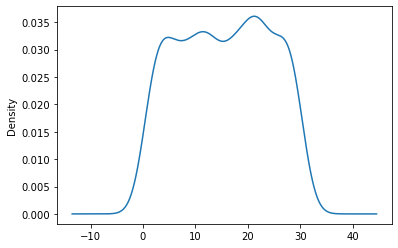

In [7]:
df1['id'].value_counts().sort_index().plot(kind='density')

We also generate a validation set. Then, we dump the data `DataSeqLoader`, which inherites `keras.utils.Sequence` class. It is a structure that sequentialize data into batches of correct shape and format (similar to dataset & dataloader in PyTorch). 

In our usage, we reformat the tabular feature data into `num_predictors x (batch_size, timesteps, 1)`. We can change the argument `many_to_one: bool` to control the output data's shape: `(batch_size, 1)` for `True` and `(batch_size, timesteps, 1)` for `False`.

In [48]:
df2 = data_gen(n=400, p=20, max_t=30)
dl1 = DataSeqLoader(
    X=df1.drop(["id", "y"], axis=1),
    y=df1["y"],
    ids=df1["id"],
    max_t=30,
    batch_size=8,
    many_to_one=False,
)
dl2 = DataSeqLoader(
    X=df2.drop(["id", "y"], axis=1),
    y=df2["y"],
    ids=df2["id"],
    max_t=30,
    batch_size=8,
    many_to_one=False,
)

/Users/scots/Desktop/Duke Univeristy/Research/EHR missing data/embedding/embedding_missingdata/data_utils.py:100: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self._rawX[var] = self._rawX[var].fillna("Missing")
100%|██████████| 1000/1000 [00:10<00:00, 94.44it/s]
/Users/scots/Desktop/Duke Univeristy/Research/EHR missing data/embedding/embedding_missingdata/data_utils.py:100: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self._rawX[var] = self._rawX[var].fillna("Missing")
100%|██████████| 400/400 [00:04<00:00, 95.11it/s] 


In [49]:
dl1.categorical_vars_info

{'C1': 6, 'C2': 3}

In [76]:
x = dl1.data_seqs[3][0][0][-1]
TimeDistributedOneHotEncoding(num_tokens=5)(x)

<tf.Tensor: shape=(8, 4, 5), dtype=float32, numpy=
array([[[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
     

The model did not implement padding.

In theory, LSTM/RNN models share weights along the time dimension, allowing input data to have varying timesteps. However, in practice, samples in the same batch must share the same timesteps during the training process (because of the way TF/Keras was built). Some engieering tircks has been implemented to ensure that when construct the dataloader.

In [82]:
10 * ((np.log(10)/ np.log(3)) ** 2)

43.92810535176964

In [97]:
em = EmbeddingLSTMModel(dl1, False, 2)
em.build()

(None, None, 6)
(None, None, 3)


2024-01-25 11:50:45.417074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-25 11:50:45.419529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-25 11:50:45.421854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [66]:
em.model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x0_indct (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 x1_indct (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 x2_indct (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 x3_indct (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                           

In [96]:
em.fit(val_data=dl2, filepath="./example.hdf5", metric_curve="ROC", epochs=5)

Epoch 1/5


2024-01-25 11:50:33.877581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-25 11:50:35.534068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-25 11:50:35.535805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

KeyboardInterrupt: 

In [16]:
em_no_miss = EmbeddingLSTMModel(dl_no_miss, True, 2)
em_no_miss.build()

2023-10-26 22:34:04.139239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
em_no_miss.fit(val_data=dl_no_miss, filepath="./example.hdf5", metric_curve="ROC", epochs=5)

Epoch 1/5
63/63 [==============================] - 8s 44ms/step - loss: 0.6687 - auc: 0.5587 - val_loss: 0.6420 - val_auc: 0.5488
Epoch 2/5
63/63 [==============================] - 1s 18ms/step - loss: 0.5921 - auc: 0.4848 - val_loss: 0.5127 - val_auc: 0.5165
Epoch 3/5
63/63 [==============================] - 1s 18ms/step - loss: 0.4651 - auc: 0.5001 - val_loss: 0.4308 - val_auc: 0.4997
Epoch 4/5
63/63 [==============================] - 1s 17ms/step - loss: 0.4295 - auc: 0.4864 - val_loss: 0.4197 - val_auc: 0.5098
Epoch 5/5
63/63 [==============================] - 1s 18ms/step - loss: 0.4176 - auc: 0.5107 - val_loss: 0.4113 - val_auc: 0.5204


In [43]:
import tensorflow as tf

In [47]:
tf.constant([1,2])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

In [48]:
tf.__version__

'2.9.1'